In [1]:
%matplotlib inline

In [2]:
from sklearn.cross_validation import train_test_split
import pandas as pd

from passage.models import RNN
from passage.updates import Adadelta
from passage.updates import NAG, Regularizer
from passage.layers import Embedding, GatedRecurrent, Dense
from passage.preprocessing import *

from sklearn import preprocessing, metrics
from matplotlib import pyplot as plt

Using gpu device 0: GRID K520


In [3]:
fn = '../../devel.txt'

In [4]:
tr_data = pd.read_csv(fn, encoding='utf-8', sep=r'\t+', header=None, names=['text', 'label'], engine='python')

In [5]:
grps = tr_data.groupby(['label'])

In [6]:
train_df = pd.DataFrame(columns=['text','label'])
test_df = pd.DataFrame(columns=['text','label'])

for name, grp in grps:
    print name, grp.shape
    train, test = train_test_split(grp, test_size=0.25, random_state=42)

    train_df = train_df.append(train, ignore_index=True)
    test_df = test_df.append(test, ignore_index=True)

bg (2000, 2)
bs (2000, 2)
cz (2000, 2)
es-AR (2000, 2)
es-ES (2000, 2)
hr (2000, 2)
id (2000, 2)
mk (2000, 2)
my (2000, 2)
pt-BR (2000, 2)
pt-PT (2000, 2)
sk (2000, 2)
sr (2000, 2)
xx (2000, 2)


In [7]:
trX = train_df['text'].values
trY = train_df['label'].values

In [8]:
teX = test_df['text'].values
teY = test_df['label'].values

In [9]:
le = preprocessing.LabelEncoder()
trY_t = le.fit_transform(trY)
teY_t = le.transform(teY)
le.classes_

array(['bg', 'bs', 'cz', 'es-AR', 'es-ES', 'hr', 'id', 'mk', 'my', 'pt-BR',
       'pt-PT', 'sk', 'sr', 'xx'], dtype=object)

In [10]:
tokenizer = Tokenizer(min_df=1, max_features=1000000)
trX_t = tokenizer.fit_transform(trX)
print("Training data tokenized.")

Training data tokenized.


/home/ubuntu/Downloads/passage/passage/preprocessing.py:41: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if t in punctuation:


In [11]:
tokenizer.n_features

149110

In [12]:
teX_t = tokenizer.transform(teX)

In [ ]:
p_drop_scores = {}

for p_drop in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]:
    layers = [
        Embedding(size=128, n_features=tokenizer.n_features),
        GatedRecurrent(size=768, p_drop=p_drop),
        Dense(size=14, activation='softmax', p_drop=0.2)
    ]

    model = RNN(layers=layers, cost='cce', updater=Adadelta(lr=0.5))
    model.fit(trX_t, trY_t, n_epochs=10)

    pr_teX = model.predict(teX_t)
    classes = np.argmax(pr_teX, axis=1)

    acc = metrics.accuracy_score(teY_t, classes)
    p_drop_scores[p_drop] = acc

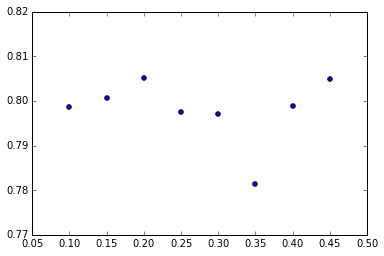

In [24]:
scores = zip(*p_drop_scores.iteritems())
plt.scatter(scores[0], scores[1])

In [ ]:
size_scores = {}

for size in [64, 128, 256, 512, 768, 1024, 1280]:
    layers = [
        Embedding(size=128, n_features=tokenizer.n_features),
        GatedRecurrent(size=size, p_drop=0.35),
        Dense(size=14, activation='softmax', p_drop=0.2)
    ]

    model = RNN(layers=layers, cost='cce', updater=Adadelta(lr=0.5))
    model.fit(trX_t, trY_t, n_epochs=10)

    pr_teX = model.predict(teX_t)
    classes = np.argmax(pr_teX, axis=1)

    acc = metrics.accuracy_score(teY_t, classes)
    size_scores[size] = acc

Epoch 0 Seen 20792 samples Avg cost 1.7675 Time elapsed 15 seconds
Epoch 1 Seen 41584 samples Avg cost 0.8298 Time elapsed 31 seconds
Epoch 2 Seen 62376 samples Avg cost 0.6080 Time elapsed 46 seconds
Epoch 3 Seen 83168 samples Avg cost 0.5133 Time elapsed 62 seconds
Epoch 4 Seen 103960 samples Avg cost 0.4550 Time elapsed 77 seconds
Epoch 5 Seen 124752 samples Avg cost 0.4042 Time elapsed 93 seconds
Epoch 6 Seen 145544 samples Avg cost 0.3580 Time elapsed 108 seconds
Epoch 7 Seen 166336 samples Avg cost 0.3131 Time elapsed 124 seconds
Epoch 8 Seen 187128 samples Avg cost 0.2523 Time elapsed 139 seconds
Epoch 9 Seen 207920 samples Avg cost 0.1902 Time elapsed 155 seconds
Epoch 0 Seen 20792 samples Avg cost 1.7555 Time elapsed 17 seconds
Epoch 1 Seen 41584 samples Avg cost 0.8124 Time elapsed 34 seconds
Epoch 2 Seen 62376 samples Avg cost 0.6210 Time elapsed 51 seconds
Epoch 3 Seen 83168 samples Avg cost 0.5219 Time elapsed 69 seconds
Epoch 4 Seen 103960 samples Avg cost 0.4512 Time ela

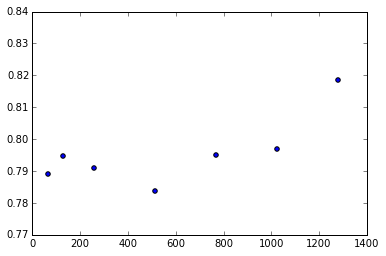

In [25]:
scores = zip(*size_scores.iteritems())
plt.scatter(scores[0], scores[1])

In [ ]:
epochs_scores = {}

for epoch in [5, 7, 10, 13, 15, 17, 20, 22, 25]:
    layers = [
        Embedding(size=128, n_features=tokenizer.n_features),
        GatedRecurrent(size=768, p_drop=0.35),
        Dense(size=14, activation='softmax', p_drop=0.2)
    ]

    model = RNN(layers=layers, cost='cce', updater=Adadelta(lr=0.5))
    model.fit(trX_t, trY_t, n_epochs=epoch)

    pr_teX = model.predict(teX_t)
    classes = np.argmax(pr_teX, axis=1)

    acc = metrics.accuracy_score(teY_t, classes)
    epochs_scores[epoch] = acc

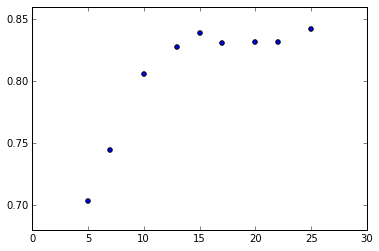

In [26]:
scores = zip(*epochs_scores.iteritems())
plt.scatter(scores[0], scores[1])

In [20]:
sizes = [768, 1024, 1280]
p_drop = [0.2, 0.25, 0.35, 0.4, 0.45]

In [21]:
from itertools import product

In [23]:
len(list(product(sizes, p_drop)))

15

In [ ]:
comb_scores = {}

for size, pd in product(sizes, p_drop):
    layers = [
        Embedding(size=128, n_features=tokenizer.n_features),
        GatedRecurrent(size=size, p_drop=pd),
        Dense(size=14, activation='softmax', p_drop=0.2)
    ]

    model = RNN(layers=layers, cost='cce', updater=Adadelta(lr=0.5))
    model.fit(trX_t, trY_t, n_epochs=25)

    pr_teX = model.predict(teX_t)
    classes = np.argmax(pr_teX, axis=1)

    acc = metrics.accuracy_score(teY_t, classes)
    comb_scores[(size, pd)] = acc

Epoch 0 Seen 20792 samples Avg cost 2.4244 Time elapsed 44 seconds
Epoch 1 Seen 41584 samples Avg cost 1.1739 Time elapsed 88 seconds
Epoch 2 Seen 62376 samples Avg cost 0.7354 Time elapsed 132 seconds
Epoch 3 Seen 83168 samples Avg cost 0.5731 Time elapsed 177 seconds
Epoch 4 Seen 103960 samples Avg cost 0.4899 Time elapsed 221 seconds
Epoch 5 Seen 124752 samples Avg cost 0.4445 Time elapsed 266 seconds
Epoch 6 Seen 145544 samples Avg cost 0.3952 Time elapsed 310 seconds
Epoch 7 Seen 166336 samples Avg cost 0.3406 Time elapsed 354 seconds
Epoch 8 Seen 187128 samples Avg cost 0.2993 Time elapsed 398 seconds
Epoch 9 Seen 207920 samples Avg cost 0.2399 Time elapsed 442 seconds
Epoch 10 Seen 228712 samples Avg cost 0.1850 Time elapsed 487 seconds
Epoch 11 Seen 249504 samples Avg cost 0.1422 Time elapsed 531 seconds
Epoch 12 Seen 270296 samples Avg cost 0.1055 Time elapsed 575 seconds
Epoch 13 Seen 291088 samples Avg cost 0.0902 Time elapsed 619 seconds
Epoch 14 Seen 311880 samples Avg cos

In [ ]:
comb_scores

{(768, 0.2): 0.81814285714285717,
 (768, 0.25): 0.84014285714285719,
 (768, 0.35): 0.82771428571428574,
 (768, 0.4): 0.83971428571428575,
 (768, 0.45): 0.85357142857142854,
 (1024, 0.2): 0.82985714285714285,
 (1024, 0.25): 0.80828571428571427,
 (1024, 0.35): 0.83542857142857141,
 (1024, 0.4): 0.83314285714285718,
 (1024, 0.45): 0.85271428571428576,
 (1280, 0.2): 0.83699999999999997,
 (1280, 0.25): 0.82271428571428573,
 (1280, 0.35): 0.83271428571428574,
 (1280, 0.4): 0.85757142857142854,
 (1280, 0.45): 0.84257142857142853}

In [ ]:
comb_scores